In [2]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode


# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot.plotters as skplt

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

from tensorflow.contrib.learn import DNNClassifier

#from tecnosmartlib import DataObject

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal
/root/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/lite/toco/python/_tensorflow_wrap_toco.so | _tensorflow_wrap_toco


In [3]:
#plt.style.use('fivethirtyeight')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Data

In [4]:
dfNoticias = pd.read_pickle("dfNoticias")

# pre procesing

Cleaning data, select clases

In [5]:
print('Selecting useful information...', end='')
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Seccion2"] = []
_map["Seccion3"] = []

count = 0
for index, row in dfNoticias.iterrows():
    if (row["Seccion_1"] != None and row["Cuerpo"] != None):
        _map["Cuerpo"].append(row["Cuerpo"]) 
        _map["Seccion"].append(row["Seccion_1"])
        _map["Seccion2"].append(row["Seccion_2"])
        _map["Seccion3"].append(row["Seccion_3"])
        if row["Seccion_1"] == row["Seccion_2"] and row["Seccion_2"] == row["Seccion_3"]:
            count += 1
        if row["Seccion_1"] == row["Seccion_2"] and row["Seccion_3"] == None:
            count += 1
        if row["Seccion_1"] == row["Seccion_3"] and row["Seccion_2"] == None:  
            count += 1 
        if row["Seccion_2"] == None and row["Seccion_3"] == None:
            count += 1      
print('done.')



Selecting useful information...done.


In [6]:
print( len(_map['Seccion2']) )
print(count)

250339
220068


In [7]:
df = pd.DataFrame(_map)
numberOfDuplicates = df.shape[0]
print('Number of data before dropping duplicates: {}'.format(df.shape[0]))
df = df.drop_duplicates(inplace= False)
df.reset_index(drop=True, inplace= True)
numberOfDuplicates -= df.shape[0]
print('Number of data after dropping duplicates : {}'.format(df.shape[0]))
print('\nNumber of duplicated data : {}'.format(numberOfDuplicates))

#df.head()

Number of data before dropping duplicates: 250339
Number of data after dropping duplicates : 238931

Number of duplicated data : 11408


In [8]:
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)

assert X_untransformed.shape[0] == y_untransformed.shape[0], 'X and y dimenssion must be the same.'
print('Number of data: {}'.format(X_untransformed.shape[0]))

Number of data: 238931


In [9]:
classes = df.groupby('Seccion')['Cuerpo'].nunique()

print(classes)
nClasses = classes.shape[0]

#print('\nNumber of classes: {}'.format(nClasses))

Seccion
Corporativo        82
Cultura          3128
Deportes        76458
Economía         6750
Entretención    29438
Mundo           31664
País            75180
Sociedad         9079
Tecnología       7130
Name: Cuerpo, dtype: int64


# Feature Extraccion

### Data representation

TFID calculation

In [10]:

start = time.time()
print("start")


spanish_stopwords = stopwords.words('spanish')
def normalize_text(text):
    return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
                      if len(x) > 1 and x not in spanish_stopwords])

X_untransformed = X_untransformed
n_docs = X_untransformed.shape[0]
n_cpu = 20

batch_size = int(n_docs/n_cpu)

wb = wordbatch.WordBatch(normalize_text, 
                         extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                              "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                              "idf": 1.0}), procs=n_cpu, n_words=1000, minibatch_size=batch_size)
wb.dictionary_freeze = True
word_comment = wb.fit_transform(list(X_untransformed),reset= False)
X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

end = time.time()
print("TFIDF end time :" + str(end - start) )


X = X_transformed
print('Number of features: {}'.format(X.shape[1]))

start
Normalize text
Extract wordbags
TFIDF end time :97.16177678108215
Number of features: 1000


### Output

In [20]:
class DataObject():
    def __init__(self, x, y):
        self.X = x
        self.Y = y

        try:
            self.Y.reset_index(drop=True, inplace=True)
        except:
            pass

        self.X_train = self.X
        self.Y_train = self.Y

        self.X_test  = None
        self.Y_test  = None

        self.X_test_dense = None

        self.k = 0
#     def next_train_batch(self, batch_size):
#         indexes = np.random.choice(self.X_train.shape[0], size=batch_size, replace=False)
#         return self.X_train[indexes], self.Y_train.reindex(indexes)

    def set_train_test(self,train_fraction = None, test_fraction = None, dense=True):
        # Tests for create subsets
        if train_fraction == None and test_fraction == None:
            train_fraction = 0.8
        elif train_fraction == None:
            assert 0 <= test_fraction and test_fraction < 1, 'Test fraction must be in [0,1)'
            train_fraction = 1 - test_fraction
        else:
            assert 0 < train_fraction and train_fraction <= 1, 'Train fraction must be in (0,1]'

        train_indices = np.random.choice(self.X.shape[0], round(train_fraction*self.X.shape[0]), replace=False)
        test_indices = np.array(list(set(range(self.X.shape[0])) - set(train_indices)))

        self.X_train = self.X[train_indices]
        self.Y_train = self.Y.reindex(train_indices)
        self.Y_train = self.Y_train.reset_index()

        self.X_test = self.X[test_indices]
        self.Y_test = self.Y.reindex(test_indices)
        self.Y_test = self.Y_test.reset_index()
        if dense:
            self.X_test_dense = self.X_test.todense()
        return True


Y = y_untransformed
Y = Y.reset_index(drop=True)

def remove_accents(a):
    return unidecode.unidecode(a)

data = DataObject(X,Y.apply(remove_accents))

labels = [remove_accents(x) for x in list(data.Y.unique())]
#print(labels)

data.set_train_test(0.8)
#print(data.Y_train.reset_index(drop=True))

True

# Model

### DNN graph generation

In [12]:
tf.set_random_seed(42)

feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=1000)]

classifier = DNNClassifier(                                
                           n_classes=nClasses, label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000, 1000, 100],
                           dropout=0.5,
                           weight_column_name='class_weights',
                           model_dir = './model-parallel/seccion_dnn4', #./model-parallel/seccion_dnn
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f22b55d59b0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './model-parallel/seccion_dnn4'}


### functions graph tensorflow

In [27]:
epochs = 14000

# Define the test inputs
def get_train_inputs():
    print("Paso por aca.........................")
    X_ = data.X_train
    Y_ = data.Y_train
    X_ = X_.todense()
    x = X_
    Y_ = Y_['Seccion'].reset_index(drop=True)
#     y = y.apply(remove_accents)
#     y = y.values

    y = Y_.values
    
    # computing lengths of each class
    sizes = {label: Y_[Y_ == label].shape[0] for label in labels}
#     print(sizes)

    # creating weights for each sample
    scale_factor = 10e3
    weights = np.asarray([1.0/sizes[label] for label in y])
    weights = scale_factor*weights
    weights = weights[:,np.newaxis]
    print('weights shape: {}'.format(weights.shape))
    print(x)
    print(type(x))
    print(weights)
    print(type(weights))
    print(y)
    print(type(y))    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': x, 'class_weights': weights}, y[:,np.newaxis], shuffle=True, batch_size=500, num_epochs=epochs)
    return dataset

def get_test_inputs():
    X_ = data.X_test_dense
    Y_ = data.Y_test
#     X_ = X_.todense()
    x = X_
    Y_ = Y_['Seccion'].reset_index(drop=True)
    y = Y_.values
    
    # computing lengths of each class
    sizes = {label: Y_[Y_ == label].shape[0] for label in labels}
#     print(sizes)

    # creating weights for each sample
    scale_factor = 10e3
    weights = np.asarray([1.0/sizes[label] for label in y])
    weights = scale_factor*weights
    weights = weights[:,np.newaxis]
    print('weights shape: {}'.format(weights.shape))
    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': x, 'class_weights': weights}, y[:,np.newaxis], shuffle=False)
    return dataset


In [28]:
get_train_inputs()

Paso por aca.........................
weights shape: (191145, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.matrixlib.defmatrix.matrix'>
[[0.1663008 ]
 [0.39536631]
 [1.84365782]
 ...
 [0.16322   ]
 [0.39536631]
 [0.426094  ]]
<class 'numpy.ndarray'>
['Pais' 'Mundo' 'Economia' ... 'Deportes' 'Mundo' 'Entretencion']
<class 'numpy.ndarray'>


<function tensorflow.python.estimator.inputs.numpy_io.numpy_input_fn.<locals>.input_fn>

# Training



In [14]:


validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn= get_test_inputs(),
    every_n_steps=500,
    #early_stopping_metric="accuracy",#loss
    early_stopping_metric="accuracy",
    early_stopping_metric_minimize=False,
    early_stopping_rounds=7000)

classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

weights shape: (47786, 1)
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Paso por aca.........................
weights shape: (191145, 1)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt-6
INFO:tensorflow:Saving checkpoints for 7 into ./model-parallel/seccion_dnn4/model.ckpt.
INFO:tensorflow:loss = 0.8570804, step = 7
INFO:tensorflow:global_step/sec: 23.08
INFO:tensorflow:loss = 0.92045987, step = 107 (4.336 sec)
INFO:tensorflow:global_step/sec: 23.7332
INFO:tensorflow:loss = 1.5002038, step = 207 (4.214 sec)
INFO:tensorflow:global_step/sec: 23.5442
INFO:tensorflow:loss = 0.9069738, step = 307 (4.246 sec)
INFO:tensorflow:global_step/sec: 23.1828
INFO:tensorflow:loss = 0.91863513, step = 407 (4.313 sec)
INFO:tensorflow:Starting evaluation at 2018-08-20-18:39:39
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt-7
INFO:tensorflow:Finished 

INFO:tensorflow:Finished evaluation at 2018-08-20-18:42:51
INFO:tensorflow:Saving dict for global step 3507: accuracy = 0.73251045, global_step = 3507, loss = 0.7807777
INFO:tensorflow:Validation (step 4000): loss = 0.7807777, accuracy = 0.73251045, global_step = 3507
INFO:tensorflow:Saving checkpoints for 4007 into ./model-parallel/seccion_dnn4/model.ckpt.
INFO:tensorflow:global_step/sec: 10.7013
INFO:tensorflow:loss = 0.32864574, step = 4007 (9.344 sec)
INFO:tensorflow:global_step/sec: 22.5374
INFO:tensorflow:loss = 0.30121875, step = 4107 (4.437 sec)
INFO:tensorflow:global_step/sec: 22.5044
INFO:tensorflow:loss = 0.35041907, step = 4207 (4.444 sec)
INFO:tensorflow:global_step/sec: 22.6546
INFO:tensorflow:loss = 0.3150419, step = 4307 (4.414 sec)
INFO:tensorflow:global_step/sec: 23.0296
INFO:tensorflow:loss = 0.29806703, step = 4407 (4.341 sec)
INFO:tensorflow:Starting evaluation at 2018-08-20-18:43:14
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt

INFO:tensorflow:Validation (step 8000): loss = 0.73560417, accuracy = 0.7468358, global_step = 7507
INFO:tensorflow:Saving checkpoints for 8007 into ./model-parallel/seccion_dnn4/model.ckpt.
INFO:tensorflow:global_step/sec: 10.8504
INFO:tensorflow:loss = 0.33784428, step = 8007 (9.217 sec)
INFO:tensorflow:global_step/sec: 22.6316
INFO:tensorflow:loss = 0.2203061, step = 8107 (4.418 sec)
INFO:tensorflow:global_step/sec: 23.4633
INFO:tensorflow:loss = 0.28918692, step = 8207 (4.262 sec)
INFO:tensorflow:global_step/sec: 22.8985
INFO:tensorflow:loss = 0.29672107, step = 8307 (4.368 sec)
INFO:tensorflow:global_step/sec: 22.4552
INFO:tensorflow:loss = 0.29898006, step = 8407 (4.452 sec)
INFO:tensorflow:Starting evaluation at 2018-08-20-18:46:50
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt-8007
INFO:tensorflow:Finished evaluation at 2018-08-20-18:46:54
INFO:tensorflow:Saving dict for global step 8007: accuracy = 0.7374948, global_step = 8007, loss = 0.755

INFO:tensorflow:global_step/sec: 10.9203
INFO:tensorflow:loss = 0.25567472, step = 12007 (9.159 sec)
INFO:tensorflow:global_step/sec: 22.4687
INFO:tensorflow:loss = 0.18484287, step = 12107 (4.451 sec)
INFO:tensorflow:global_step/sec: 22.4183
INFO:tensorflow:loss = 0.1982371, step = 12207 (4.461 sec)
INFO:tensorflow:global_step/sec: 22.7053
INFO:tensorflow:loss = 0.20254074, step = 12307 (4.403 sec)
INFO:tensorflow:global_step/sec: 22.6975
INFO:tensorflow:loss = 0.17667174, step = 12407 (4.407 sec)
INFO:tensorflow:Starting evaluation at 2018-08-20-18:50:26
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt-12007
INFO:tensorflow:Finished evaluation at 2018-08-20-18:50:30
INFO:tensorflow:Saving dict for global step 12007: accuracy = 0.74069893, global_step = 12007, loss = 0.7608244
INFO:tensorflow:Validation (step 12500): loss = 0.7608244, accuracy = 0.74069893, global_step = 12007
INFO:tensorflow:Saving checkpoints for 12507 into ./model-parallel/seccion_

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7f22b55d5ef0>, 'hidden_units': [2000, 1000, 100], 'feature_columns': (_RealValuedColumn(column_name='x', dimension=1000, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7f237fd0f730>, 'dropout': 0.5, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

# Evaluation performance


In [15]:
def input_fn_evaluate():
    dataset = {'x': tf.constant(data.X_test_dense)}
    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)

# print(pred_test)

y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)
y_test = data.Y_test['Seccion'].values
y_test = y_test.astype(str)
print('Test shape: {}\nReal shape: {}'.format(y_test_hat.shape, y_test.shape))

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)
print('Accuracy in test: {}'.format(acc))





INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn4/model.ckpt-14006
Test shape: (47786,)
Real shape: (47786,)
Accuracy in test: 0.8402251705520445


In [16]:
#predict_proba = classifier.predict_proba(input_fn=input_fn_evaluate,as_iterable=False)
#np.sum(predict_proba, axis=1)

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


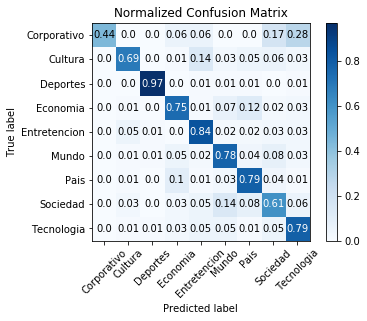

In [17]:

ax = skplt.plot_confusion_matrix(y_test, y_test_hat,normalize=True)
plt.xticks(rotation=45)

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

#plt2.xticks(rotation=70)